In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sympy import symbols, cos, sin, pi, simplify, atan2, acos, init_printing, sqrt
from sympy.matrices import Matrix
import sympy as sp
init_printing()

# Project: Kinematics Pick & Place
---

Here I present the approach that I followed to code IK_server.py

## Representation of urdf file

To help with debugging I wrote some functions that read the simplified urdf file that defines Kuka arm Kr210. This will help with visualizing the difference in representation between Denavit–Hartenberg and urdf.
First let's write a function to draw three arrows in 3d space representing a local frame of reference.

In [2]:
def add_frame(axes, origin, x1, x2, rep='XZ'):
    """
    Takes an matplotlib 3d axes and adds a triplet of arroys representing origin coordinates
    The frame of reference can be passed defined with two vectors representing x and z unit vectors,
    xy unit vectors or yz unit vectors. The third component is calculated"""
    org = np.vstack((origin, origin, origin))
    if rep == 'XZ':
        x = np.array(x1)
        z = np.array(x2)
        y = np.cross(x2, x1)
    elif rep == 'XY':
        x = np.array(x1)
        y = np.array(x2)
        z = np.cross(x1, x2)
    elif rep== 'YZ':
        y = np.array(x1)
        z = np.array(x2)
        x = np.cross(x1, x2)
    else:
        print('representation not valid')
    arrows = np.vstack((x,y,z))
    for arrow, color in zip(arrows, ['r','g','b']):
        # Length hardcoded for this problem. Assuming m as dimensions
        axes.quiver3D(org[0, 0], org[0, 1], org[0, 2], arrow[0], arrow[1], arrow[2],
                      length=0.3, color=color, normalize=True)
    

In [3]:
import xml.etree.ElementTree as ET
with open('./simplified_kr210.urdf') as urdf_file:
    urdf = ET.parse(urdf_file)

In [4]:
rev_joints = []
# append one representing the origin
rev_joints.append((np.array([0.0,0.0,0.0]), np.array([0.0,0.0,1.0])))
for joint in urdf.findall("joint/[@type='revolute']"):
    origin = joint.find('origin').attrib['xyz']
    axis = joint.find('axis').attrib['xyz']
    o = np.fromstring(origin, sep=' ')
    a = np.fromstring(axis, sep=' ')
    rev_joints.append((o, a))

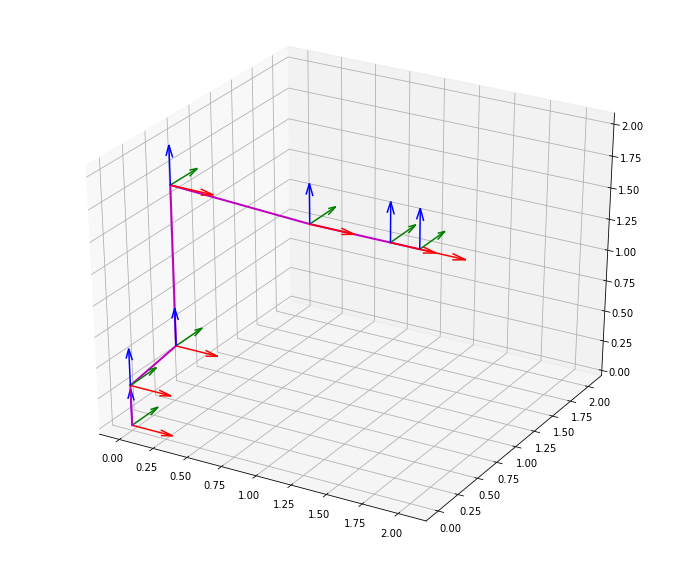

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pos = np.array([0.0,0.0,0.0])
max_coord = 0.0
for joint in rev_joints:
    base = np.array(pos)
    pos += joint[0]
    ax.plot((base[0], pos[0]), (base[1], pos[1]), linewidth=2, zs=(base[2], pos[2]), color='m')
    max_coord = max(max_coord, pos.max())
    add_frame(ax, pos, [1,0,0], [0,0,1])
ax.auto_scale_xyz([0,max_coord], [0,max_coord], Z=[0,max_coord])
#ax.set_aspect('equal')
fig.set_size_inches(12,10)

Here I ploted the joints in 3d to get an idea of what the frames look like. Read arrows represent a local x axis, green arrows a y axis, and blue would be a z axis

### Symbolic Forward Kinematics

Let's now try to get the forward kinematics in symbolic form. It is useful to build a 3d view of the frames, but this time as interpreted in DH configuration. Therefore, we first define the robot following DH convention:

In [6]:
# working with lists would make it easier latter on
q_s = symbols('q1:8', real=True)
d_s = symbols('d1:8', real=True)
a_s = symbols('a0:7', real=True)
alpha_s = symbols('alpha0:7', real=True)

alpha = [0.0, -pi/2, 0.0, -pi/2, pi/2, -pi/2, 0.0]
a = [0.0, 0.35, 1.25, -0.054, 0.0, 0.0, 0.0]
d = [0.75, 0.0, 0.0, 1.5, 0.0, 0.0, 0.303]
q = list(q_s)
q[1] = q_s[1] - pi/2
q[6] = 0.0
dh = dict(zip(a_s, a))
dh.update(dict(zip(alpha_s, alpha)))
dh.update(dict(zip(d_s, d)))
dh.update(dict(zip(q_s, q)))
# DH table
dh

A function to calculate the each transformation matrix is very useful here:

In [7]:
def transform(alpha, a, d, q):
    """
    Helper function. Given the values for a tranformation between two joints it returns
    the tranformation matrix
    """
    T = Matrix([[cos(q), -sin(q), 0.0, a],
                [sin(q) * cos(alpha), cos(q) * cos(alpha), -sin(alpha), -sin(alpha) * d],
                [sin(q) * sin(alpha), cos(q) * sin(alpha),  cos(alpha),  cos(alpha) * d],
                [0.0, 0.0, 0.0, 1.0]])
    return T

In [8]:
# list of transformations
T_s = []
for alpha, a, d, q in zip(alpha_s, a_s, d_s, q_s):
    T_s.append(transform(alpha, a, d, q).subs(dh))

Let's put numeric values into the transformations and plot then side by side with the frames of the urdf file. I just added an offset to global coordinate y to help with the comparison.

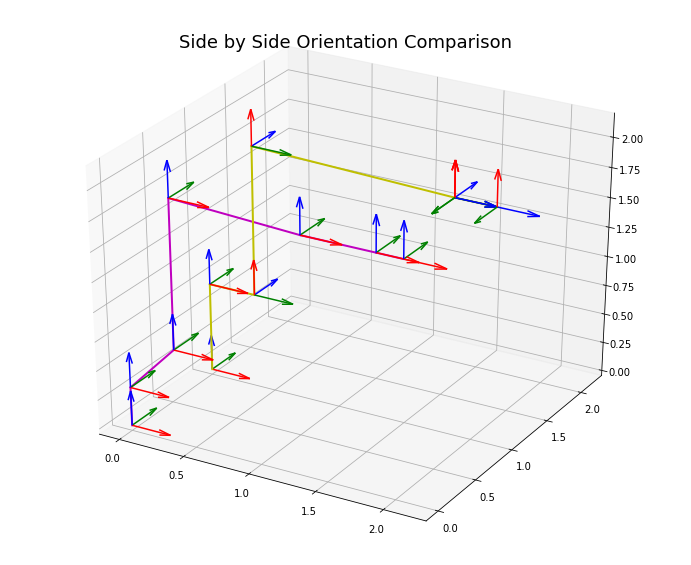

In [9]:
# base frame of reference:
pos = Matrix([0.0, 0.0, 0.0, 1.0])
x1 = Matrix([1.0, 0.0, 0.0])
x2 = Matrix([0.0, 0.0, 1.0])
# selected configuration
conf = dict(zip(q_s, [0.0] * len(q_s)))
max_coord = 0.0
origin = Matrix([0.0, 1.0, 0.0, 1.0])
add_frame(ax, origin[0:3], x1[:3], x2[:3])

# total transformation:
T = Matrix.eye(4)
joint_id = 1
for t in T_s:
    T *= t
    base = np.array(origin[:3])
    origin = (T * pos).subs(conf)
    origin[1] = 1.0
    x = T[:3, :3].subs(conf) * x1
    z = T[:3, :3].subs(conf) * x2
    max_coord = max(max_coord, max(origin))
    ax.plot((base[0], origin[0]), (base[1], origin[1]), linewidth=2, zs=(base[2], origin[2]), color='y')
    add_frame(ax, origin[:3], x[:3], z[:3])
    joint_id += 1
    
ax.auto_scale_xyz([0,max_coord], [0,max_coord], Z=[0,max_coord])
ax.set_title('Side by Side Orientation Comparison', fontsize=18)
fig

The difference in definition can be clearly seen in the picture. However, when all transformations are applied wue should end up with the same position and orientation. Looking at arrow colors we can see what the difference is for the orientation of the end effector in each definition.

### Correction of end effector

The final frame of reference needs to be rotated to match what is in the urdf file. To position it correctly, we need to rotate it -pi/2 around the y axis and pi around the z axis. For those operations let's buils generic rotation matrices:

In [10]:
rot_1, rot_2, rot_3 = symbols('rot_1:4')
R_x = Matrix([[ 1, 0, 0],
              [ 0, cos(rot_1), -sin(rot_1)],
              [ 0, sin(rot_1),  cos(rot_1)]])
R_y = Matrix([[ cos(rot_2), 0, sin(rot_2)],
              [ 0, 1, 0],
              [-sin(rot_2), 0,  cos(rot_2)]])
R_z = Matrix([[ cos(rot_3), -sin(rot_3), 0],
              [ sin(rot_3),  cos(rot_3), 0],
              [ 0, 0, 1]])

In [11]:
# Correction matrix in homogeneous form
corr = (R_z.subs(rot_3, pi) * R_y.subs(rot_2, -pi/2))
corr = corr.row_insert(3, Matrix([0,0,0]).transpose())
corr = corr.col_insert(3, Matrix([0,0,0,1]))

This correction has to be applied to the effector orientation. For that, we need to multiply our previous transformation by the correction matrix that we just defined. Let's plot the position of the first and last link using both expresions.

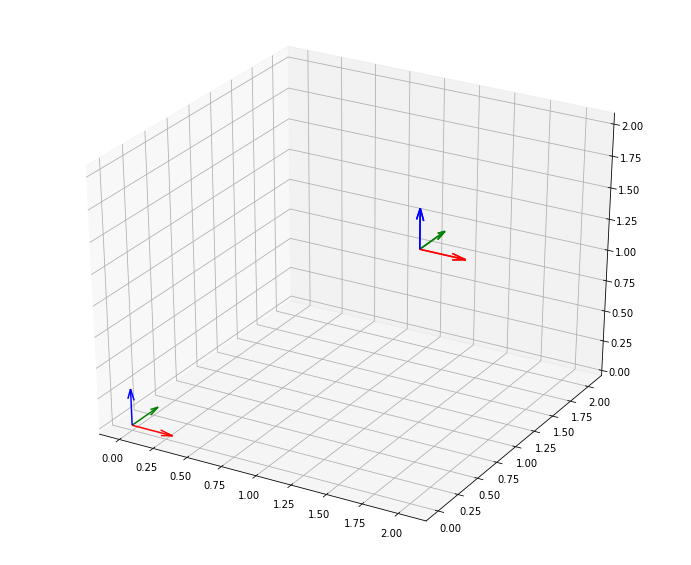

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pos = np.array([0.0,0.0,0.0])
max_coord = 0.0
# add origin reference:
add_frame(ax, pos, [1,0,0], [0,0,1])
for joint in rev_joints:
    pos += joint[0]
    max_coord = max(max_coord, pos.max())
add_frame(ax, pos, [1,0,0], [0,0,1])
# plot total transformation based on DH parameters
x1 = Matrix([1.0, 0.0, 0.0])
x2 = Matrix([0.0, 0.0, 1.0])
corrected_T = (T.subs(conf) * corr)
origin = Matrix([0.0, 0.0, 0.0, 1.0])
origin = corrected_T * pos
x = corrected_T[:3, :3] * x1
z = corrected_T[:3, :3] * x2
add_frame(ax, origin[:3], x[:3], z[:3])

ax.auto_scale_xyz([0,max_coord], [0,max_coord], Z=[0,max_coord])
#ax.set_aspect('equal')
fig.set_size_inches(12,10)

Transformations seem correct. There are really three frames in the plot. However, both transformations end up in the same point with the same orientation, thus only one frame is visible.

## Test Forward Kinematics

At this point, it should be posible to change the configuration of the arm and plot it. Let's try plotting the arm configuration using forward kinematics. We start from the configuration of joints to plot the final position of the arm.

In [13]:
# selected arbitrary configuration
q_values = [-0.65,0.45,-0.36,0.95,0.79,0.49, 0]
conf = dict(zip(q_s, q_values))

Wrist located at:
x: 1.8969, y: -1.4420, z: 1.6870
Effector located at:
x: 2.1630, y: -1.4244, z: 1.5431


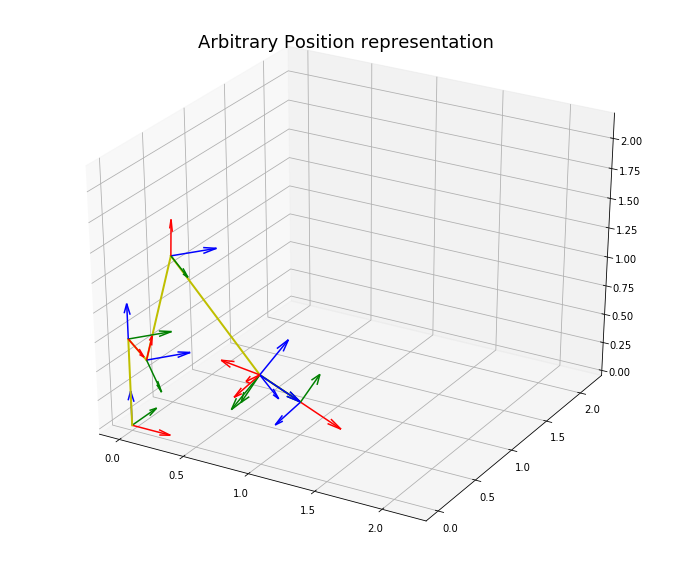

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pos = Matrix([0.0, 0.0, 0.0, 1.0])
# base frame of reference:
origin = Matrix([0.0, 0.0, 0.0, 1.0])
x1 = Matrix([1.0, 0.0, 0.0])
x2 = Matrix([0.0, 0.0, 1.0])
add_frame(ax, origin[0:3], x1[:3], x2[:3])

max_coord = 0.0
# total transformation:
T = Matrix.eye(4)
joint_id = 1
for t in T_s:
    T *= t
    base = np.array(origin[:3])
    origin = (T * pos).subs(conf)
    # correct orientation of last frame and print position
    if joint_id == len(T_s):
        x = (T[:3, :3].subs(conf) * corr[:3, :3]) * x1
        z = (T[:3, :3].subs(conf) * corr[:3, :3]) * x2
        print('Effector located at:')
        print('x: {:.4f}, y: {:.4f}, z: {:.4f}'.format(origin[0], origin[1], origin[2]))
    else:
        x = T[:3, :3].subs(conf) * x1
        z = T[:3, :3].subs(conf) * x2
    # print position of wrist (joint 4, 5, 6)
    if joint_id == 4:
        print('Wrist located at:')
        print('x: {:.4f}, y: {:.4f}, z: {:.4f}'.format(origin[0], origin[1], origin[2]))
    max_coord = max(max_coord, max(origin))
    ax.plot((base[0], origin[0]), (base[1], origin[1]), linewidth=2, zs=(base[2], origin[2]), color='y')
    add_frame(ax, origin[:3], x[:3], z[:3])
    joint_id += 1
    
ax.auto_scale_xyz([0,max_coord], [0,max_coord], Z=[0,max_coord])
ax.set_title('Arbitrary Position representation', fontsize=18)
fig.set_size_inches(12,10)

## Inverse Kinematics

In inverse kinematics we have to start with the pose we want our robot to take, and then calculate the angle of each joint.
Due to the configuration of the arm, we can decouple the problem into positioning the wrist (joints 4,5,6), and orienting the end effector. We are given the position the position and orientation of the end effector in the form of its coordinates and a quaternion. Quaternions can be converted to roll, pitch, yaw.
### Wrist Position
The first conclusion that can be reached is that theta_1 can be calculated directly from the coordinates of the wrist position. By looking at the robot configuration, it is clear that the only joint that can position the wrist in a particular plane that contains the global z axis is the first one. Looking at the robot from above (global z direction) the point of interest and the z axis are contained in a plane that forms an angle theta1 with the x axis.

In [15]:
# Transform matrix from origen to wrist
T_0_4 = simplify(T_s[0] * T_s[1] * T_s[2] * T_s[3])
origin = Matrix([0.0, 0.0, 0.0, 1.0])
# wrist center as variable
x_wc = symbols(('x_wc', 'y_wc', 'z_wc'), real=True)
wrist_center = Matrix(x_wc).row_insert(3, Matrix([1.0]))

With theta1 solved as a function of the wrist coordinates we know have to find relations for the other two angles. As we saw before, those links are in the same plane. We can make use of it to solve for the triangle formed by joints two, three and four. Then all that is left is to project those results into the plane defined by theta1.

In [16]:
theta_1 = atan2(x_wc[1], x_wc[0])
theta_1

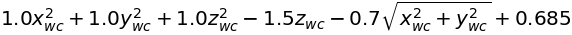

In [17]:
# Two sides of the triangle come directly from the DH table
side_b = 1.501 # sqrt(d4 ** 2 + a3 **2)
side_a = 1.25 # a2
# point at joint 2:
x_p2 = (T_s[0] * T_s[1] * origin).subs(q_s[0], theta_1)
# Distance vector between joint and wrist
distance = (wrist_center - x_p2)
side_c_sq = simplify((distance.transpose() * distance)[0])
# It is simpler to keep the square here. Apply sqrt to cos law
side_c_sq

In [18]:
# apply law of cosines to solve angles:
alpha = acos((side_b ** 2 + side_c_sq - side_a ** 2) / (2 * side_b * sqrt(side_c_sq)))
beta = acos((side_a ** 2 + side_c_sq - side_b ** 2) / (2 * side_a * sqrt(side_c_sq)))
gamma = acos((side_b ** 2 + side_a ** 2 - side_c_sq) / (2 * side_b * side_a))

In [19]:
# solve relations based on distances and angles
theta_2 = pi / 2 - beta - atan2(distance[2], sqrt(simplify(distance[0] ** 2 + distance[1] ** 2)))
theta_3 = pi / 2 - (gamma + 0.036)

### Check symbolic solution

Let's check the solution with some numerical values. We first calculate forward kinematics and the inverse

In [20]:
# selected arbitrary configuration
q_values = [-0.65,0.45,-0.36,0.95,0.79,0.49, 0.0]
conf = dict(zip(q_s, q_values))
# calculate forward kinematics up to the wrist
wrist_position = T_s[0] * T_s[1] * T_s[2] * T_s[3] * origin

In [21]:
# try to get theta values for that point
ik_test = dict(zip(x_wc, wrist_position.subs(conf)[:3]))
ik_test

In [22]:
float(theta_1.subs(ik_test)), float(theta_2.subs(ik_test)), float(theta_3.subs(ik_test))

In [23]:
round_trip = {q_s[0]: float(theta_1.subs(ik_test)), q_s[1]: float(theta_2.subs(ik_test)),
              q_s[2]: float(theta_3.subs(ik_test))}
error = (np.array(((T_s[0] * T_s[1] * T_s[2] * T_s[3]).subs(round_trip) * origin)[:3] )- 
         np.array(wrist_position.subs(conf)[0:3]))
error

array([-2.00290765102196e-5, 1.52261920738361e-5, 2.66980818943718e-5], dtype=object)

## Effector Orientation

The other part of the problem is orienting the effector. Orientation of the effector is done with the last joints. But, before doing that, we need to define it in terms of the data received. The requested orientation is defined as a quaternion. This can be easily converted to RPY (roll, pitch, yaw) using tf.transformations.euler_from_quaternion. With that information we can calculate the transformation from the origin to the end effector.

In [24]:
def quaternion2euler(q):
    """
    Helper function to convert quaternions to RPY configuration.
    Assumes same format than ros function with w as the last element (x,y,z,w)
    """
    sin_r = 2.0 * (q[3] * q[0] + q[1] * q[2])
    cos_r = 1.0 - 2.0 * (q[0] * q[0] + q[1] * q[1])
    roll = np.arctan2(sin_r, cos_r)
    sin_p = 2.0 * (q[3] * q[1] - q[2] * q[0])
    if (abs(sin_p) >= 1):
        pitch = copysign(np.pi / 2, sin_p) # use 90 degrees if out of range
    else:
        pitch = np.arcsin(sin_p)
    sin_y = 2.0 * (q[3] * q[2] + q[0] * q[1])
    cos_y = 1.0 - 2.0 * (q[1] * q[1] + q[2] * q[2])
    yaw = atan2(sin_y, cos_y)
    return roll, pitch, yaw

In [25]:
# Asummed a RPY configuration converted from quaternion
roll = symbols('r', real=True)
pitch = symbols('p', real=True)
yaw = symbols('y', real=True)
ee_x = symbols('ee_x', real=True)
ee_y = symbols('ee_y', real=True)
ee_z = symbols('ee_z', real=True)
e_qua = [0.708611,0.186356,-0.157931,0.661967]
ee_orient = quaternion2euler(e_qua)
ee_pos = [2.16135, -1.42635, 1.55109]
ee_conf = {ee_x: ee_pos[0], ee_y: ee_pos[1], ee_z: ee_pos[2],
           roll: ee_orient[0], pitch: ee_orient[1], yaw: ee_orient[2]}

# Transformation from global coords to end effector corrected to use DH coordinates
T_0_eff = R_z.subs(rot_3, yaw) * R_y.subs(rot_2, pitch) * R_x.subs(rot_1, roll)
T_0_eff = T_0_eff.row_insert(3, Matrix([0, 0, 0]).transpose())
T_0_eff = T_0_eff.col_insert(3, Matrix([ee_x, ee_y, ee_z,1])) * corr
T_0_eff

⎡sin(p)⋅cos(r)⋅cos(y) + sin(r)⋅sin(y)  -sin(p)⋅sin(r)⋅cos(y) + sin(y)⋅cos(r)  
⎢                                                                             
⎢sin(p)⋅sin(y)⋅cos(r) - sin(r)⋅cos(y)  -sin(p)⋅sin(r)⋅sin(y) - cos(r)⋅cos(y)  
⎢                                                                             
⎢           cos(p)⋅cos(r)                         -sin(r)⋅cos(p)              
⎢                                                                             
⎣                 0                                      0                    

cos(p)⋅cos(y)  eeₓ ⎤
                   ⎥
sin(y)⋅cos(p)  ee_y⎥
                   ⎥
   -sin(p)     ee_z⎥
                   ⎥
      0         1  ⎦

### Wrist Center Position
In this particular case, we know from the robot configuration that the last four links in the chain are just equivalent to a translation in the z axis of the effector. In other words, the effector position is just a translation from the wrist center. This information would give us the fastest calculation:

$$T^{eff}_0 \times \begin{bmatrix}
0.0 \\
0.0 \\
-0.303 \\
1.0 \\
\end{bmatrix}
$$

The -0.303 is the amount we move in the local z direction. It is negative for a translation from end effector to wrist center

In [26]:
wrist_position = T_0_eff * Matrix([0.0, 0.0, -0.303, 1.0])
wrist_position

⎡1.0⋅eeₓ - 0.303⋅cos(p)⋅cos(y) ⎤
⎢                              ⎥
⎢1.0⋅ee_y - 0.303⋅sin(y)⋅cos(p)⎥
⎢                              ⎥
⎢   1.0⋅ee_z + 0.303⋅sin(p)    ⎥
⎢                              ⎥
⎣             1.0              ⎦

At this point we already have what we need to find the wrist position from the requested end efector pose.

In [27]:
ik_conf = dict(zip(x_wc, wrist_position.subs(ee_conf)[:3]))
ik_conf

### End Effector Orientation

We have already stablished that we can get the values of theta 1 to 3 if we know the position of the wrist center:

In [28]:
theta_1_3 = (float(theta_1.subs(ik_conf)), float(theta_2.subs(ik_conf)), float(theta_3.subs(ik_conf)))
ik_conf.update(dict(zip(q_s[:3], theta_1_3)))
ik_conf

Orientation of the effector is done with the last joints. Something worth notting is that we can write the expresion for the orientation of the end effector as:
$EE_{orient} = T^1_0 \times T^2_1 \times T^3_2 \times T^4_3 \times T^5_4 \times T^6_5 \times T^7_6\times Corr$

Now we have to find the remaining angles. For that, it is useful to notice that we can separate our transfomation in the following maner (including the correction to change from urdf to DH):

$$T^{eff}_0 \times Corr= T^3_0 \times T^E_3$$

Left multipliying both sides by $({T^3_0})^{-1}$ we have:

$$({T^3_0})^{-1} \times T^{eff}_0 \times Corr= T^E_3$$

On that equation we know everything on the left side at this point. Let's calculate each term. I tried to invert the matrix using LU decomposition. In any case it gave me big errors. In the end, I switched to sympy's default method (gauss elimination and I got good results

In [29]:
T_3_E = ((T_s[0].subs(ik_conf) * T_s[1].subs(ik_conf) * T_s[2].subs(ik_conf)).inv()[:3, :3] *
         T_0_eff.subs(ee_conf)[:3, :3])
T_3_E

⎡-0.0199009905237367  -0.911238957526371  -0.411397025830798⎤
⎢                                                           ⎥
⎢ 0.626376133662457   -0.332078655702323  0.705249392488225 ⎥
⎢                                                           ⎥
⎣-0.779266892504902   -0.24365411696335   0.577387029238243 ⎦

This transformation matrix can be converted to roll, pitch, yaw configuration. By looking at the robot configuration we see that those rotations correspond to the rotation of the last 3 joints (disregarding the last translation to the end effector). Thus, from the components of this matrix we get the final 3 angles:

In [30]:
theta_4 = atan2(T_3_E[2, 2], -T_3_E[0, 2])
theta_5 = atan2(sqrt(T_3_E[0, 2] ** 2 + T_3_E[2, 2] ** 2), T_3_E[1, 2])
theta_6 = atan2(-T_3_E[1, 1], T_3_E[1, 0])
ik_conf.update(dict(zip(q_s[3:6], [float(theta_4), float(theta_5), float(theta_6)])))
ik_conf

Let's apply forward kinematics to check the solution.

In [31]:
print('Wrist Position Error:')
print((wrist_position.subs(ee_conf) - (T_s[0] * T_s[1] * T_s[2] * T_s[3] * origin).subs(ik_conf)).evalf()[:3])

Wrist Position Error:
[2.00964408687554e-5, -1.53071585982101e-5, -2.66009843405968e-5]


In [32]:
print('End Effector Position Error:')
np.array(ee_pos) - np.array((T.subs(ik_conf)[:3,3])).astype('float64')[:,0]

End Effector Position Error:


array([  2.00964409e-05,  -1.53071586e-05,  -2.66009843e-05])

## Examples

With symbolic matrices precalculated, it is quite simple to solve another chain:

In [33]:
# Full case configuration from Rviz
ee_qua = [0.684884,-0.510046, -0.34054, -0.393472]
ee_orient = quaternion2euler(ee_qua)
ee_pos = [0.743086, -0.618487, 0.0619249]
ee_conf = {ee_x: ee_pos[0], ee_y: ee_pos[1], ee_z: ee_pos[2],
           roll: ee_orient[0], pitch: ee_orient[1], yaw: ee_orient[2]}
q_values = [-0.630919088657, 0.5503197815830001, 1.1023063526474997,
            -5.9156191294200005, -0.59952061455, -2.68658539149, 0.0]
conf = dict(zip(q_s, q_values))

In [34]:
# input known values into configuration dict
ik_conf = dict(zip(x_wc, wrist_position.subs(ee_conf)[:3]))
ik_conf.update(ee_conf)

In [35]:
# Update configuration with thetas 1 to 3
theta_1_3 = (float(theta_1.subs(ik_conf)), float(theta_2.subs(ik_conf)), float(theta_3.subs(ik_conf)))
ik_conf.update(dict(zip(q_s[:3], theta_1_3)))
ik_conf

In [36]:
T_0_3 = (T_s[0].subs(ik_conf) * T_s[1].subs(ik_conf) * T_s[2].subs(ik_conf))[:3, :3]
T_0_3_inv = T_0_3.inv()
T_3_E = T_0_3_inv * T_0_eff.subs(ik_conf)[:3, :3]

In [37]:
theta_4 = atan2(T_3_E[2, 2], -T_3_E[0, 2])
theta_5 = atan2(sqrt(T_3_E[0, 2]*T_3_E[0, 2] + T_3_E[2, 2]*T_3_E[2, 2]), T_3_E[1, 2])
theta_6 = atan2(-T_3_E[1, 1], T_3_E[1, 0])
ik_conf.update(dict(zip(q_s[3:6], [float(theta_4), float(theta_5), float(theta_6)])))


In [38]:
print('Wrist Position Error:')
print((wrist_position.subs(ee_conf) - (T_s[0] * T_s[1] * T_s[2] * T_s[3] * origin).subs(ik_conf)).evalf()[:3])

Wrist Position Error:
[-2.13906409149978e-5, 1.56263523533040e-5, -2.53780614146715e-5]


In [39]:
print('End Effector Position Error:')
np.array(ee_pos) - np.array((T.subs(ik_conf)[:3,3])).astype('float64')[:,0]

End Effector Position Error:


array([ -2.13906409e-05,   1.56263524e-05,  -2.53780614e-05])

## IK_server.py modifications

The code build up to this point is fine for working interactively in a notebook. However, it would not be reasonable to run all this symbolic calculations time and again for each pose. For this reason, I precomputed most some of the matrices in the global scope of the script. That way, most of the calculations are subtitutions on expresions. To improve speed more, I used lambdify from sympy.

### Running the solution.

To run the solution, all that was left was to follow the instructions given by launching ros with the provided safe_spawner script as well as starting IK_server.py